### CREDIT RISK MANAGEMENT

This jupyter notebook contains all codes and conclusion which are made while working with final credit risk management task of the skillbox platform.

### Author : Umidjon Sattorov. Student at skillbox platform and junior machine learning engineer.


In [2]:
#Importing necessary modules and libraries 
#Data processing
import pandas as pd 
import numpy as np 

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

#Preprocessing and feature engineering 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
#from sklearn.ensemble import IsolationForest


#Modelling 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool


#Metrics
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, precision_score, recall_score

Important information about the structure of the dataset and features:

1) id - Application ID. Applications are numbered so that the higher number corresponds to the later application date.

2) rn - Serial number of the loan product in the credit history. A higher number corresponds to a product with a later opening date.

3) pre_since_opened - Days from the date of opening the loan to the date of data collection (binarized*)

4) pre_since_confirmed - Days from the date of confirmation of loan information to the date of data collection (binarized*)

5) pre_pterm - Planned number of days from the loan opening date to the closing date (binarized*)

6) pre_fterm - Actual number of days from the loan opening date to the closing date (binarized*)

7) pre_till_pclose - Planned number of days from the date of data collection to the loan closing date (binarized*)

8) pre_till_fclose - Actual number of days from the date of data collection to the loan closing date (binarized*)

9) pre_loans_credit_limit - Credit limit (binarized*)

10) pre_loans_next_pay_summ - The amount of the next loan payment (binarized*)

11) pre_loans_outstanding - Remaining outstanding loan amount (binarized*)

12) pre_loans_total_overdue - Current overdue debt (binarized*)

13) pre_loans_max_overdue_sum - Maximum overdue debt (binarized*)

14) pre_loans_credit_cost_rate - Total cost of the loan (binarized*)

15) pre_loans5 - Number of overdues up to 5 days (binarized*)

16) pre_loans530 - Number of overdues from 5 to 30 days (binarized*)

17) pre_loans3060 - Number of overdues from 30 to 60 days (binarized*)

18) pre_loans6090 - Number of overdues from 60 to 90 days (binarized*)

19) pre_loans90 - Number of overdues by more than 90 days (binarized*)

20) is_zero_loans_5 - Flag: no overdue payments up to 5 days

21) is_zero_loans_530 - Flag: no overdue from 5 to 30 days

22) is_zero_loans_3060 - Flag: no overdue from 30 to 60 days

23) is_zero_loans_6090 - Flag: no overdue from 60 to 90 days

24) is_zero_loans90 - Flag: no overdue for more than 90 days

25) pre_util - Ratio of the remaining unpaid loan amount to the credit limit (binarized*)

26) pre_over2limit - Ratio of current overdue debt to credit limit (binarized*)

27) pre_maxover2limit - Ratio of maximum overdue debt to credit limit (binarized*)

28) is_zero_util - Flag: the ratio of the remaining unpaid loan amount to the credit limit is 0

29) is_zero_over2limit - Flag: the ratio of the current overdue debt to the credit limit is 0

30) is_zero_maxover2limit - Flag: the ratio of the maximum overdue debt to the credit limit is 0

31) enc_paym_{0..N} - Statuses of monthly payments for the last N months (coded**)

32) enc_loans_account_holder_type - Loan relationship type (coded**)

33) enc_loans_credit_status - Loan status (encoded**)

34) enc_loans_account_cur - Loan currency (encoded**)

35) enc_loans_credit_type - Loan type (encoded**)

36) pclose_flag - Flag: the planned number of days from the loan opening date to the closing date is not defined

37) fclose_flag - Flag: the actual number of days from the loan opening date to the closing date is not defined

* the field value range is divided into N non-overlapping intervals, each interval is randomly assigned a unique number from 0 to N-1, the field value is replaced by the number of the interval to which it belongs

** each unique field value is randomly assigned a unique number from 0 to K, the field value is replaced by the number of this value

In [3]:
#Reading all of the data from the dataset providen
data = []
for i in range(0, 12, 1) :
    df_sample = pd.read_parquet(path = f'./data/train_data_{i}.pq')
    data.append(df_sample)

df = pd.concat(data)
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [3]:
df.duplicated().sum()

0

In [10]:
#Sample Data Review
df[df['id'] == 0]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0
5,0,6,5,0,11,8,12,11,4,2,...,3,3,3,4,1,2,3,1,0,1
6,0,7,3,9,1,2,12,14,15,5,...,3,3,3,4,1,3,4,1,0,0
7,0,8,2,9,2,3,12,14,15,5,...,3,3,3,4,1,3,4,1,0,0
8,0,9,1,9,11,13,14,8,2,5,...,3,3,3,4,1,2,4,1,0,0
9,0,10,7,9,2,10,8,8,16,4,...,3,3,3,4,1,2,4,1,0,0


In [11]:
#Sample Data Review
df[df['id'] == 1]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
10,1,1,8,7,12,15,9,1,1,2,...,0,3,3,4,1,3,4,1,0,0
11,1,2,8,7,13,2,9,1,6,2,...,3,3,3,4,1,3,4,1,0,0
12,1,3,15,7,7,6,9,1,6,2,...,3,3,3,4,1,3,4,1,0,0
13,1,4,15,3,7,6,9,1,6,2,...,3,3,3,4,1,3,1,1,0,0
14,1,5,14,4,7,6,9,1,3,2,...,0,1,0,1,1,3,4,1,0,0
15,1,6,14,14,1,0,13,13,0,2,...,3,3,3,4,1,3,4,1,0,0
16,1,7,14,3,8,11,6,13,6,2,...,3,3,3,4,1,3,1,1,0,0
17,1,8,10,14,2,14,13,5,14,0,...,0,0,0,1,1,3,4,1,0,0
18,1,9,10,14,15,9,13,3,10,2,...,3,3,3,4,1,3,4,1,0,0
19,1,10,13,6,0,1,14,8,16,4,...,0,0,0,1,1,2,3,1,0,0


In [10]:
df.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [14]:
#Checking the size of the dataset 
df.shape

(26162717, 61)

In [17]:
#Checking empty values for every column 
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

It seems like there is not any empty values in my dataset. So this is not gonna be challenging problem. Because I consider the empty values as the most pressurizing problem.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26162717 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64
 17  pre_loans6090                  int64
 18  pre_loans90                    int64
 19  is_z

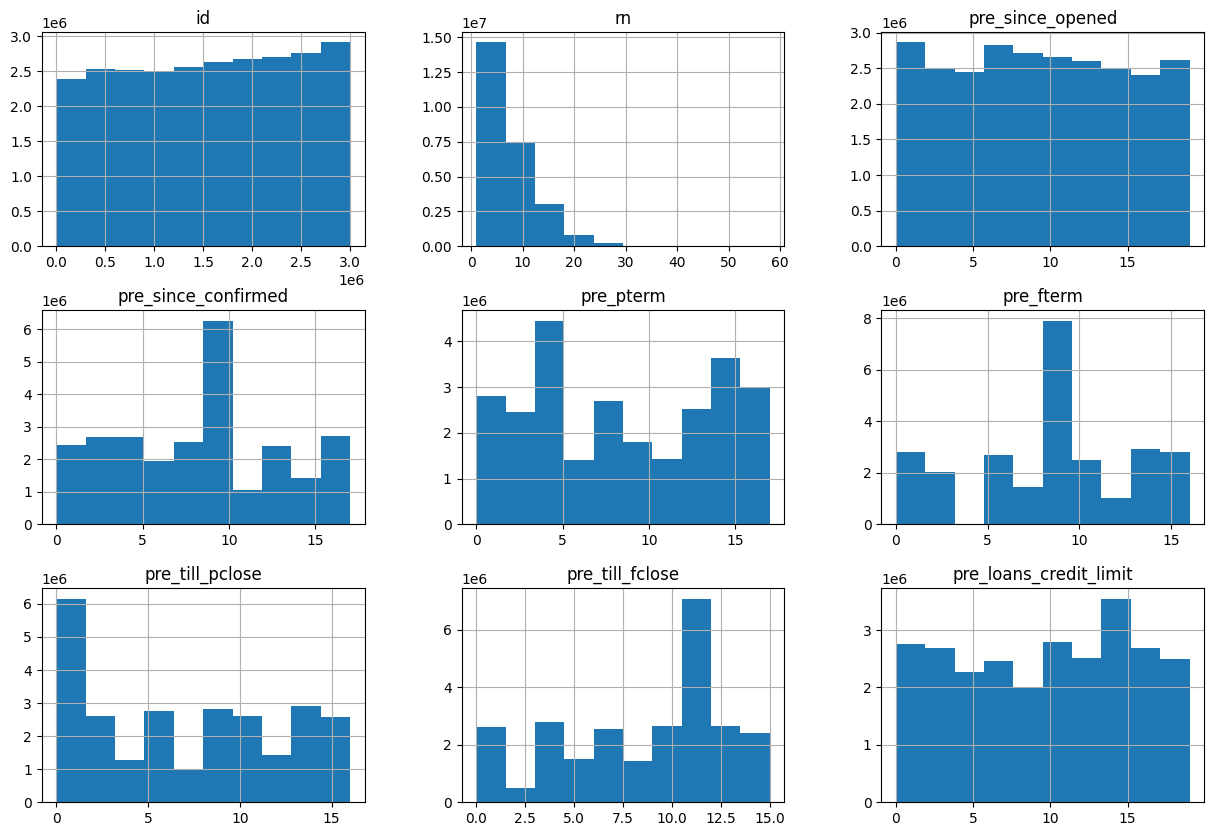

In [23]:
#Distribution of the data in numerical features
df[['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit']].hist(figsize=(15, 10))
plt.show()

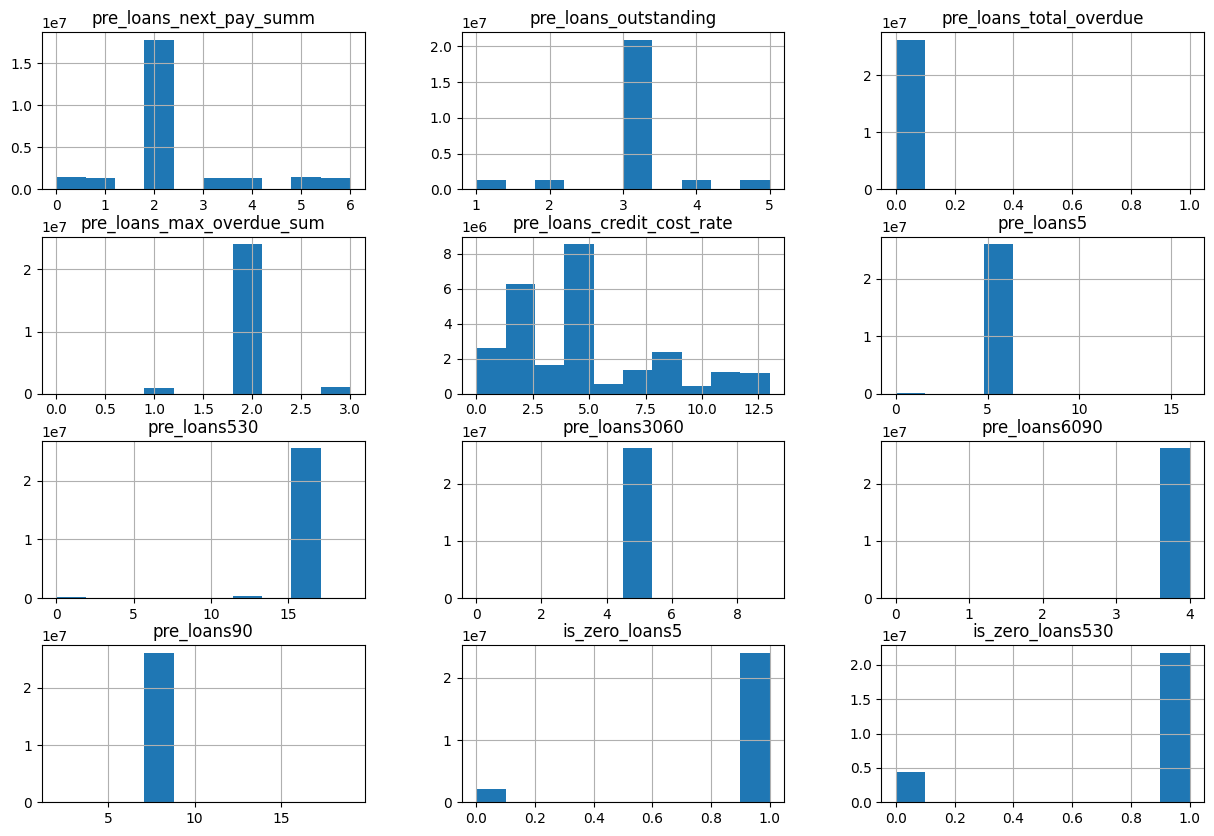

In [4]:
#Distribution of the data in numerical features
df[['pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5', 'is_zero_loans530']].hist(figsize=(15, 10))
plt.show()

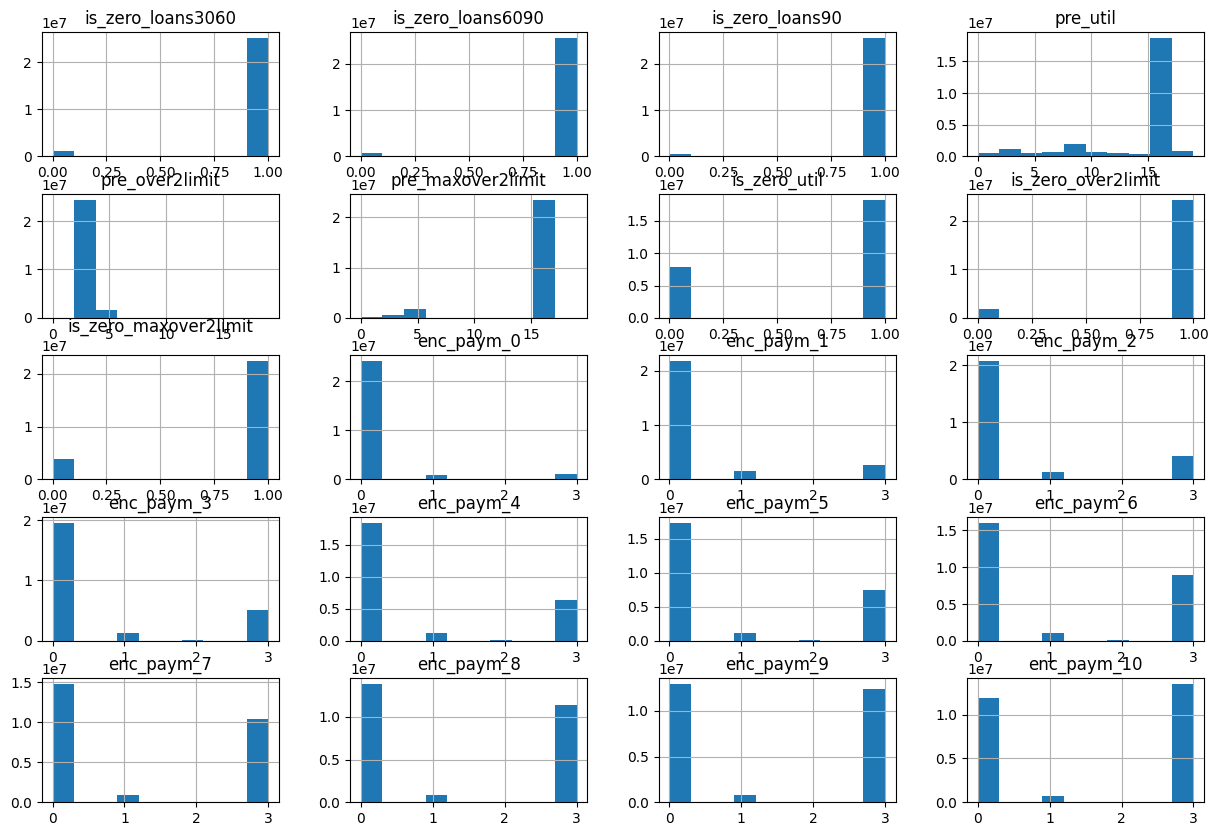

In [6]:
#Distribution of the data in numerical features
df[['is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10']].hist(figsize=(15, 10))
plt.show()

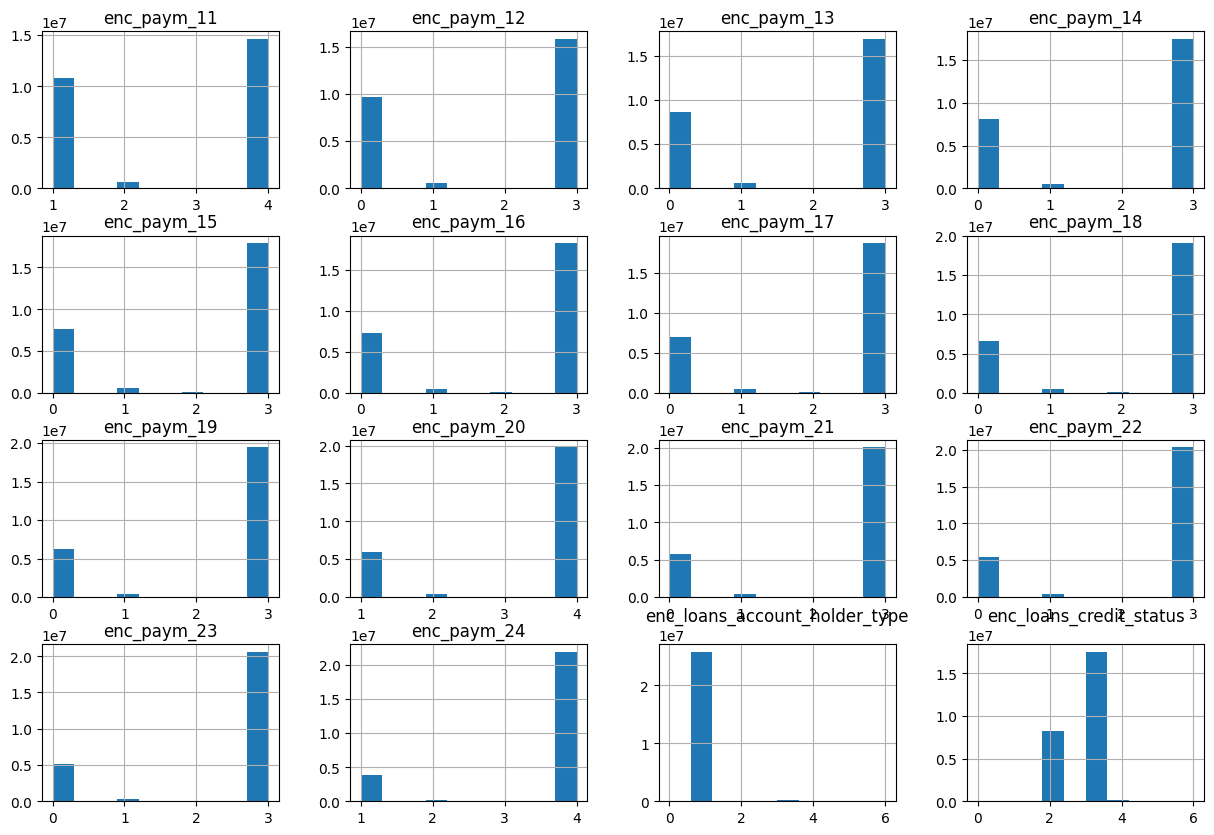

In [7]:
#Distribution of the data in numerical features
df[['enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_type', 'enc_loans_credit_status']].hist(figsize=(15, 10))
plt.show()

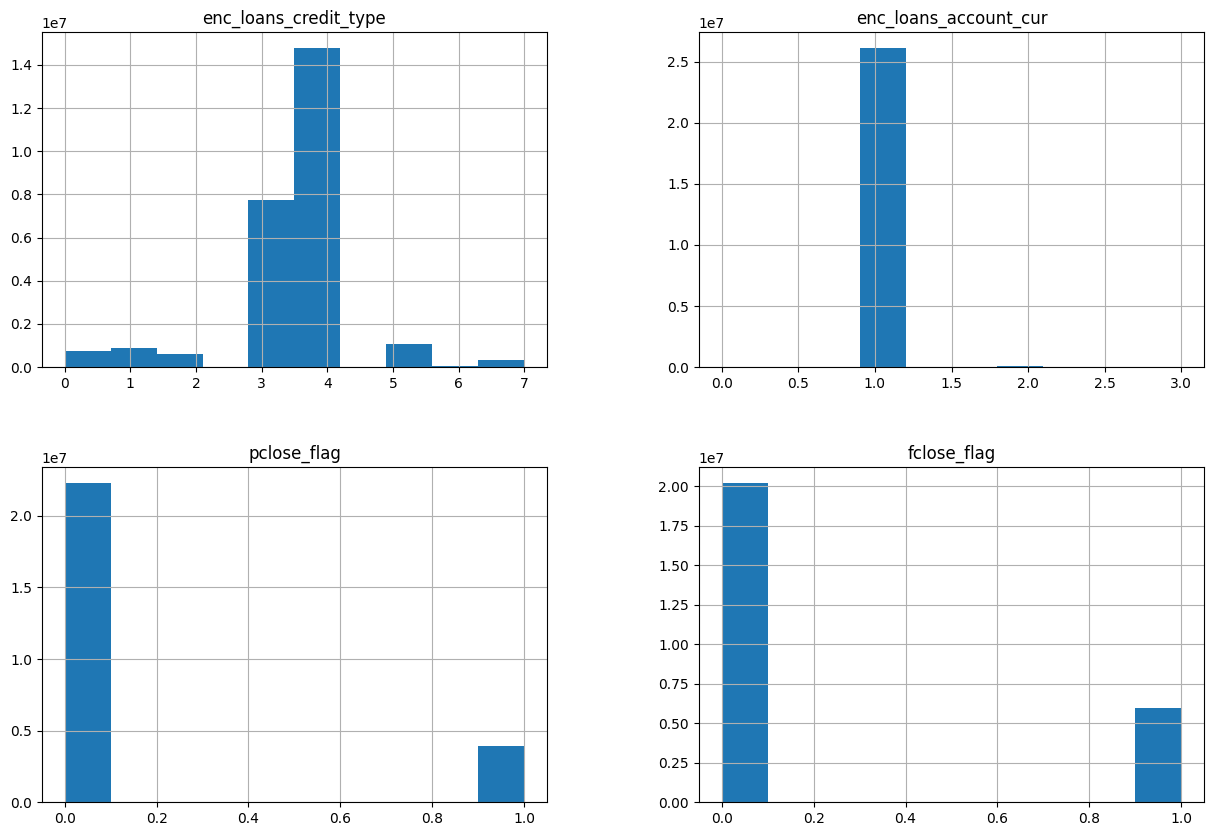

In [8]:
#Distribution of the data in numerical features
df[['enc_loans_credit_type', 'enc_loans_account_cur', 'pclose_flag', 'fclose_flag']].hist(figsize=(15, 10))
plt.show()

From the graphs above it seems like there are some feature that are binary. Even the feature enc_loans_account_cur seemed like there is one unique value. That is why I was about to remove this feature from my dataset. But the result of the code below demonstrated completely another conclusion. So I kept them in my database.

In [12]:
#Checking wheter the column enc_loans_account_cur has one unique value
df['enc_loans_account_cur'].value_counts()

enc_loans_account_cur
1    26100882
2       53102
0        8550
3         183
Name: count, dtype: int64

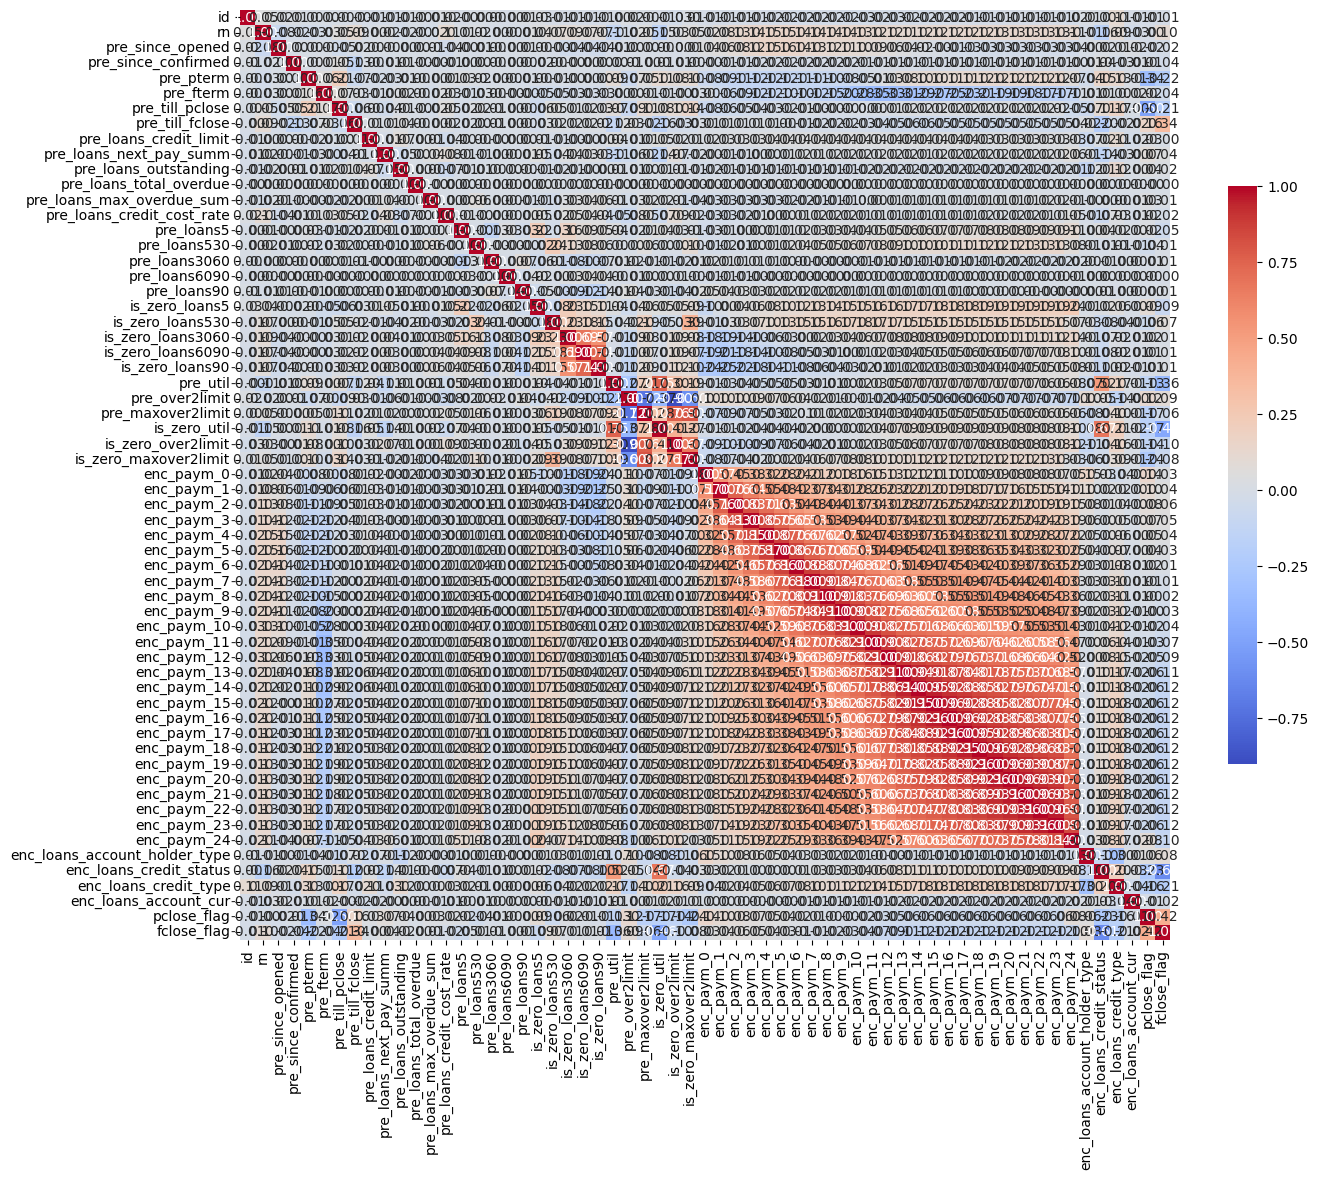

In [11]:
#Correlation matrix of the features
corr_matrix = df.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.show()

"""

From non-understandable data correlation matrix above, we only see that there are higher correlation between enc_paym_N(status of the payment for N month). Moreover there is also negative and positive relationship among the columns pre_util, pre_over2limit, pre_maxover2limit, is_zero_util, is_zero_over2limit and is_zero_maxover2limit.

I think, I have to make new feature out of existing ones to decrease the size of the dataset which I am working with. In that regard, I am going to calculate following features and remove the previous ones

1) total_enc_paym = sum(enc_pay_{i}) - this measure indicates the status of the payment for bank user for two years. Instead of calculating the status of the user to each month, I have decided to generize this feature and make new feature which indicate the capability of the user to repay their loans.

2) deviation_pfterm = pre_fterm - pre_pterm - this measure how much days user of the bank doesn't pay the loan back to bank or how much days before the user paid their loan.

3) total_overdues = pre_loans5 + pre_loans530 + pre_loans3060 + pre_loans6090 + pre_loans90 - this measure the number of overdue that user had over the period of 90 days.

4) deviation_till_close_pfdates = pre_till_pclose - pre_till_fclose - this measure the difference between expected number of days until the close of credit and actual number of days until the close of the credit. This measure indicates user behaviour mroe precisely compared to previous features.

"""

In [3]:
"""

#Total_enc_paym new feature
df['total_enc_paym'] = df[[f'enc_paym_{i}' for i in np.arange(0, 25, 1)]].sum(axis = 1)
df.drop(columns = [f'enc_paym_{i}' for i in np.arange(0, 25, 1)], inplace = True)
df.shape

"""

(26162717, 37)

In [4]:
"""

#deviation_pfterm new feature for indicating how much days people didn't pay their loans or paid loan beforehand
df['deviation_pfterm'] = df['pre_fterm'] - df['pre_pterm']
df.drop(columns = ['pre_pterm', 'pre_fterm'], inplace = True)
df.shape

"""

(26162717, 36)

In [5]:
"""

#deviation_till_close_pfdates new feature 
df['deviation_till_close_pfdates'] = df['pre_till_pclose'] - df['pre_till_fclose']
df.drop(columns = ['pre_till_pclose', 'pre_till_fclose'], inplace = True)
df.shape

"""

(26162717, 35)

In [6]:
"""

#total_overdues new feature to the dataset
df['total_overdues'] = df['pre_loans5'] + df['pre_loans530'] + df['pre_loans3060'] + df['pre_loans6090'] + df['pre_loans90']
df.drop(columns = ['pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90'], inplace = True)
df.head()

"""

,id,rn,pre_since_opened,pre_since_confirmed,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,total_enc_paym,deviation_pfterm,deviation_till_close_pfdates,total_overdues
0,0,1,18,9,11,3,3,0,2,11,...,1,3,4,1,0,0,72,1,6,39
1,0,2,18,9,0,3,3,0,2,11,...,1,3,4,1,0,0,6,0,0,39
2,0,3,18,9,11,0,5,0,2,8,...,1,2,3,1,1,1,6,4,-10,39
3,0,4,4,1,12,2,3,0,2,4,...,1,3,1,1,0,0,43,3,9,39
4,0,5,5,12,10,2,3,0,2,4,...,1,3,4,1,0,0,57,-13,-1,39


While working on the dataset in other jupyter notebook, I came across that some features of the dataset are coded. That is why I think I don't treat them as numerical feature, but rather like categorical feature. Therefore, I am going to encode them using OneHotEncorder before aggregating the data for similar ids.

Moreover while envisioning the structure of the dataset, I found columns of the data contain even categorical features. I call them as cat_cols. Here we can see the structure of the data. I will treat them as categorical feature and encode them using OneHotEncoder.

In [4]:
coded_features = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
              'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14',
              'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
              'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_type', 'enc_loans_credit_status',
              'enc_loans_credit_type', 'enc_loans_account_cur']

binary_cols = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 
               'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 
               'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060',
               'pre_loans6090', 'pre_loans90', 'pre_util', 'pre_over2limit','pre_maxover2limit']

flag_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util',
             'is_zero_over2limit', 'is_zero_maxover2limit', 'pclose_flag', 'fclose_flag']

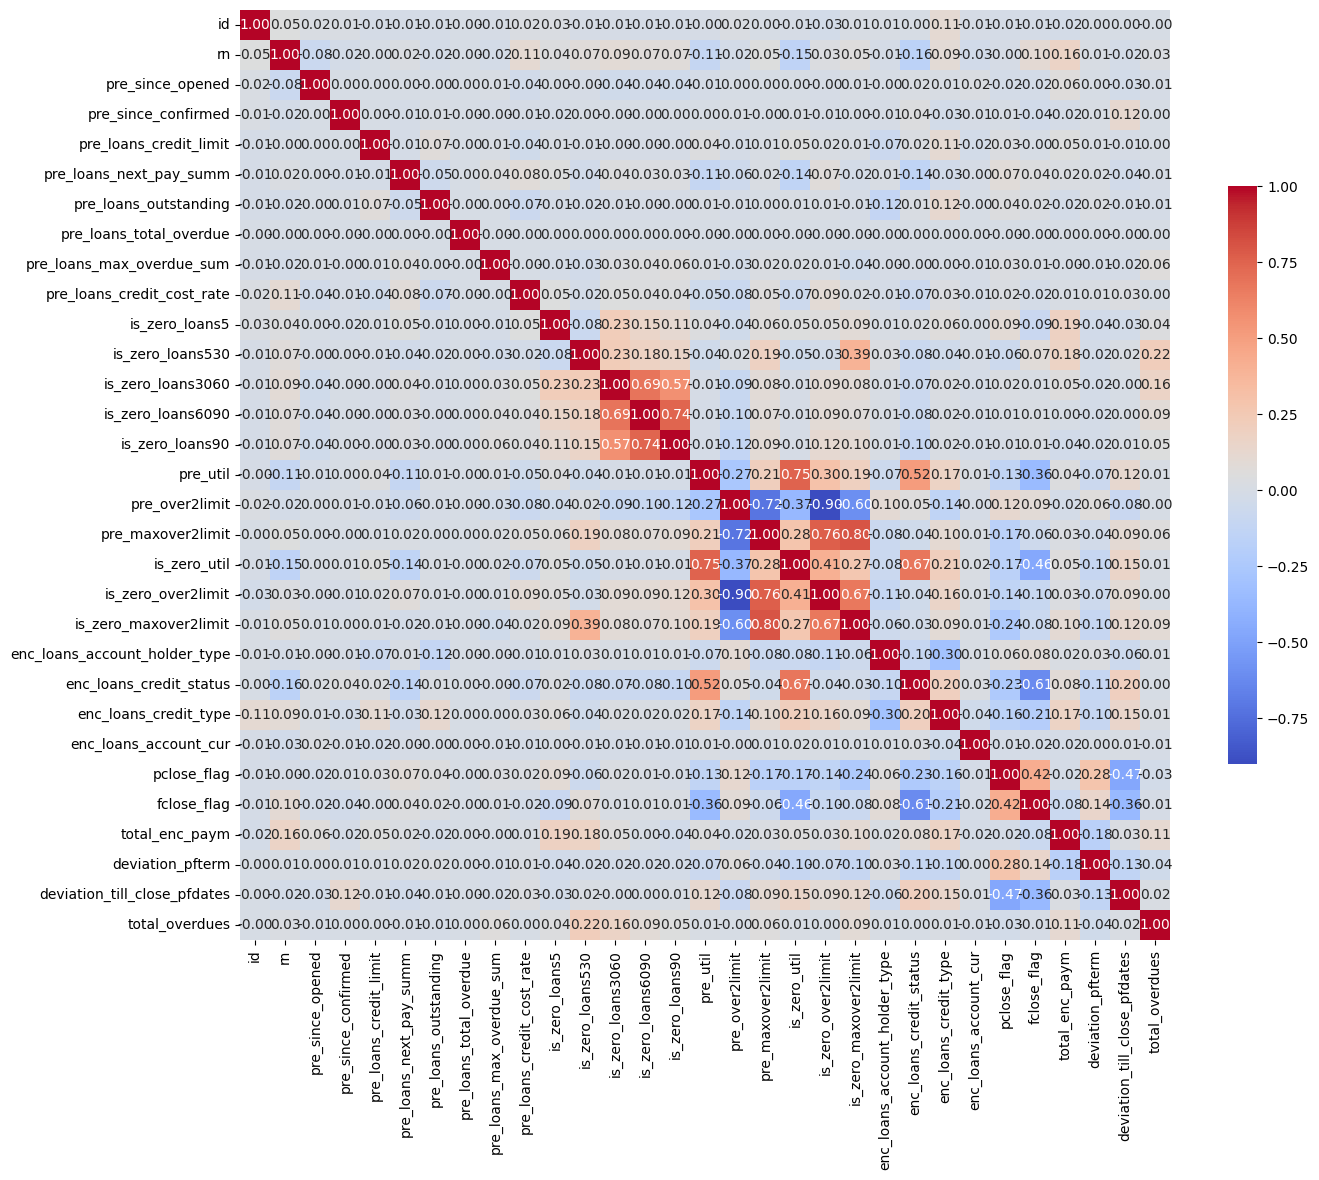

In [7]:
"""

#Correlation matrix of the features
corr_matrix = df.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.show()

"""

I have aggregated highly correlated features into one column and make more meaningful information for my machine learning model. But there are also some highly correlated feature which might potentially diminish the quality of the machine learning model. That is why, I am going to make new features out of columns 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit'.

I think I can remove the features like 'is_zero_util', is_zero_over2limit, is_zero_maxover2limit as they have high correlation with their counterparts. The 'pre_util', 'pre_over2limit', 'pre_maxover2limit' features can easily provide the information and variability to our machine learning model.

In [2]:
"""

df.drop(columns = ['is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit'], inplace = True)

"""

"\n\ndf.drop(columns = ['is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit'], inplace = True)\n\n"

Because the dataset is large and the information for same id is huge, I am going to get the mean values of the features (except binary features) and save them to my new dataframe

In [5]:
mean_cols = ['rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_over2limit', 'pre_maxover2limit', 'enc_loans_account_holder_type', 'enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_account_cur', 'pclose_flag', 'fclose_flag', 'total_enc_paym', 'deviation_pfterm', 'deviation_till_close_pfdates', 'total_overdues']

mode_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']

In [17]:
agg_dict = {col: 'mean' for col in mean_cols}
agg_dict.update({col: lambda x: x.mode()[0] for col in mode_cols})

result = df.groupby(by='id').agg(agg_dict).reset_index()
result.head(10)

,id,rn,pre_since_opened,pre_since_confirmed,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,fclose_flag,total_enc_paym,deviation_pfterm,deviation_till_close_pfdates,total_overdues,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90
0,0,5.5,8.100000,7.600000,9.600000,3.100000,2.900000,0.0,2.000000,8.000000,...,0.200000,42.700000,0.400000,0.700000,39.000000,1,1,1,1,1
1,1,7.5,11.428571,7.642857,8.142857,2.142857,2.928571,0.0,1.928571,3.714286,...,0.142857,44.285714,1.285714,3.071429,39.000000,1,1,1,1,1
2,2,2.0,8.333333,10.666667,1.666667,1.333333,3.000000,0.0,1.666667,4.000000,...,0.666667,49.666667,-1.000000,-4.000000,34.333333,1,1,1,1,1
3,3,8.0,7.000000,7.333333,9.866667,2.600000,3.266667,0.0,2.000000,4.466667,...,0.400000,28.800000,0.200000,-2.933333,39.000000,1,1,1,1,1
4,4,1.0,12.000000,9.000000,12.000000,1.000000,3.000000,0.0,2.000000,0.000000,...,1.000000,78.000000,4.000000,-10.000000,39.000000,1,1,1,1,1
5,5,2.5,8.750000,4.500000,11.750000,2.500000,2.750000,0.0,1.250000,6.000000,...,0.250000,48.500000,0.500000,-0.750000,39.000000,1,0,1,1,1
6,6,9.5,9.222222,8.166667,11.055556,2.166667,3.055556,0.0,2.000000,4.000000,...,0.055556,34.500000,-1.000000,1.111111,39.000000,1,1,1,1,1
7,7,1.5,7.000000,13.000000,3.500000,4.000000,3.500000,0.0,2.000000,2.000000,...,1.000000,76.500000,4.000000,-10.000000,39.000000,1,1,1,1,1
8,8,2.0,11.000000,5.666667,14.000000,4.666667,3.666667,0.0,2.000000,2.666667,...,0.333333,58.000000,3.333333,2.000000,39.000000,1,1,1,1,1
9,9,1.0,6.000000,12.000000,12.000000,2.000000,3.000000,0.0,2.000000,4.000000,...,0.000000,25.000000,8.000000,-2.000000,23.000000,1,0,0,0,1


In [18]:
result.shape

(3000000, 27)

In [19]:
#Reading and outputting dataframe with target variable 
target_df = pd.read_csv(filepath_or_buffer = './data/train_target.csv')
target_df.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [20]:
#Adding target column to the dataframe
total_df = pd.merge(result, target_df, on='id', how='left')
total_df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,total_enc_paym,deviation_pfterm,deviation_till_close_pfdates,total_overdues,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,flag
0,0,5.5,8.100000,7.600000,9.600000,3.100000,2.900000,0.0,2.000000,8.000000,...,42.700000,0.400000,0.700000,39.000000,1,1,1,1,1,0
1,1,7.5,11.428571,7.642857,8.142857,2.142857,2.928571,0.0,1.928571,3.714286,...,44.285714,1.285714,3.071429,39.000000,1,1,1,1,1,0
2,2,2.0,8.333333,10.666667,1.666667,1.333333,3.000000,0.0,1.666667,4.000000,...,49.666667,-1.000000,-4.000000,34.333333,1,1,1,1,1,0
3,3,8.0,7.000000,7.333333,9.866667,2.600000,3.266667,0.0,2.000000,4.466667,...,28.800000,0.200000,-2.933333,39.000000,1,1,1,1,1,0
4,4,1.0,12.000000,9.000000,12.000000,1.000000,3.000000,0.0,2.000000,0.000000,...,78.000000,4.000000,-10.000000,39.000000,1,1,1,1,1,0


In [21]:
#Saving the resulting dataframe to csv format 
total_df.to_csv(path_or_buf = './data/train_full.csv', sep = ',', index = False)
print("Dataframe successfully saved to train_full.csv file!")

Dataframe successfully saved to train_full.csv file!


Because the dataset we have worked with was pretty large, I have just decided to save my dataframe to csv format. If there is any other data processing is needed, I will work with the dataset which I have made

### Feature engineering

In [3]:
#Reading dataframe from csv file
full_df = pd.read_csv(filepath_or_buffer = './data/train_full.csv', sep = ',')
full_df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_over2limit,pre_maxover2limit,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,total_enc_paym,deviation_pfterm,deviation_till_close_pfdates,total_overdues,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,flag
0,0,5.5,8.100000,7.600000,9.600000,3.100000,2.900000,0.0,2.000000,8.000000,2.300000,15.700000,1.0,2.600000,3.500000,1.0,0.100000,0.200000,42.700000,0.400000,0.700000,39.000000,1,1,1,1,1,0
1,1,7.5,11.428571,7.642857,8.142857,2.142857,2.928571,0.0,1.928571,3.714286,2.428571,15.857143,1.0,2.714286,3.142857,1.0,0.071429,0.142857,44.285714,1.285714,3.071429,39.000000,1,1,1,1,1,0
2,2,2.0,8.333333,10.666667,1.666667,1.333333,3.000000,0.0,1.666667,4.000000,2.000000,15.000000,1.0,2.333333,3.333333,1.0,0.666667,0.666667,49.666667,-1.000000,-4.000000,34.333333,1,1,1,1,1,0
3,3,8.0,7.000000,7.333333,9.866667,2.600000,3.266667,0.0,2.000000,4.466667,2.200000,16.133333,1.0,2.533333,3.600000,1.0,0.333333,0.400000,28.800000,0.200000,-2.933333,39.000000,1,1,1,1,1,0
4,4,1.0,12.000000,9.000000,12.000000,1.000000,3.000000,0.0,2.000000,0.000000,2.000000,17.000000,1.0,2.000000,3.000000,1.0,1.000000,1.000000,78.000000,4.000000,-10.000000,39.000000,1,1,1,1,1,0


Checking if the dataset is unbalanced or not

In [23]:
#Checking if the dataset is unbalanced or not
full_df['flag'].value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

"""

There might be outlier in the dataset, that is why it is more important for us to remove outliers from the dataset.

"""

In [4]:
"""

#Checking if there is any outlier in the dataset using Isolation Forests
isf = IsolationForest(n_estimators = 8, contamination = 0.005, random_state = 1)
outlier_data = isf.fit_predict(full_df)
full_df['outlier'] = outlier_data

"""

In [8]:
"""

#The size of the outlier data in the dataset
(outlier_data == -1).sum()

"""

14996

In [11]:
"""

#Removing anomaly data from the dataset
full_df = full_df[full_df['outlier'] != -1]

"""

I have tried to remove the outlier from my dataset, but it negatively affected the quality of my model. This I am going to skip this stage of the modelling.

In [6]:
#Data Normalization
full_df_normalized = pd.DataFrame()

min_max = MinMaxScaler()
full_df_normalized[mean_cols] = min_max.fit_transform(full_df[mean_cols])
full_df_normalized.head() 

,rn,pre_since_opened,pre_since_confirmed,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_over2limit,pre_maxover2limit,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,total_enc_paym,deviation_pfterm,deviation_till_close_pfdates,total_overdues
0,0.157895,0.426316,0.447059,0.505263,0.516667,0.475000,0.0,0.666667,0.615385,0.121053,0.826316,0.090909,0.433333,0.500000,0.333333,0.100000,0.200000,0.529333,0.527273,0.506452,0.575758
1,0.228070,0.601504,0.449580,0.428571,0.357143,0.482143,0.0,0.642857,0.285714,0.127820,0.834586,0.090909,0.452381,0.448980,0.333333,0.071429,0.142857,0.550476,0.554113,0.582949,0.575758
2,0.035088,0.438596,0.627451,0.087719,0.222222,0.500000,0.0,0.555556,0.307692,0.105263,0.789474,0.090909,0.388889,0.476190,0.333333,0.666667,0.666667,0.622222,0.484848,0.354839,0.434343
3,0.245614,0.368421,0.431373,0.519298,0.433333,0.566667,0.0,0.666667,0.343590,0.115789,0.849123,0.090909,0.422222,0.514286,0.333333,0.333333,0.400000,0.344000,0.521212,0.389247,0.575758
4,0.000000,0.631579,0.529412,0.631579,0.166667,0.500000,0.0,0.666667,0.000000,0.105263,0.894737,0.090909,0.333333,0.428571,0.333333,1.000000,1.000000,1.000000,0.636364,0.161290,0.575758


Yes the dataset is unbalanced. This can pose problem for my machine learning model. However I can use SMOTE and other techniques to solve this problem. If the SMOTE is not going to work, I will use weight assigning to improve the quality of the classification problem.

In [22]:
#Dividing dataset into training and test sets
x = full_df.drop(columns = ['id', 'flag'])
y = full_df['flag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

In [8]:
#Using smote for balancing dataset
os = SMOTE(random_state = 1)

x_train_resampled, y_train_resampled = os.fit_resample(X = x_train, y = y_train)
y_train_resampled.value_counts()

flag
0    2025486
1    2025486
Name: count, dtype: int64

In [29]:
#Training Random Forest Classifier with default parameters
model = RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state = 1)
model.fit(X = x_train_resampled, y = y_train_resampled)

print(f"The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) {roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])}")
print(f"The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])}")

The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) 0.6347581375425986
The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) 0.6376271234257002


In [47]:
#Using gridsearch for finding optimal hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500]                
}

gs = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 1), param_distributions = param_grid, cv = 10, n_iter = 100, scoring = 'roc_auc', verbose = 1, n_jobs = 1)
gs.fit(X = x_train_resampled, y = y_train_resampled)

print(f"Best parameters found: {gs.best_params_}")
print(f"Best cross-validation roc_auc_score: {gs.best_score_}")

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 5 candidates, totalling 50 fits


KeyboardInterrupt: 

Because the gridsearch and random search cv requires tremendous computational power, I thought it would be better if I use weight assignment for training random forest classifier rather than finding hyperparameters for my model

In [9]:
#Calculating class weights 
class_counts = y_train.value_counts().reset_index()
class_counts.columns = ['class', 'count']
class_counts['class_weight'] = len(y_train) / class_counts['count']

class_weights = class_counts.set_index('class')['class_weight'].to_dict()

In [31]:
#Random forests with weight assignment
rm_weight = RandomForestClassifier(n_estimators = 50, max_depth = 8, random_state = 1, class_weight = class_weights, min_samples_split = 2, min_samples_leaf = 5)
rm_weight.fit(X = x_train, y = y_train)

print(f"The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) {roc_auc_score(y_train, rm_weight.predict_proba(x_train)[:, 1])}")
print(f"The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) {roc_auc_score(y_test, rm_weight.predict_proba(x_test)[:, 1])}")

The Roc auc score of Random Forest algorithm with default parameters is(Train dataset) 0.6877896883974817
The Roc auc score of Random Forest algorithm with default parameters is(Test dataset) 0.6838385017863738


Because gridsearch required more computational power from my computer, I found optimal hyperparameters manually and I have reached maximum of 69 roc_auc score with random forests algorithms with weight assignment.

Here I will try to use StratifiedKFold and random selection of the data from major class to improve the quality of the model. Moreover I will try to use other machine learning algorithms to see any improvement in the prediction.

### Using StratifiedKFlod 

In [12]:
kf = StratifiedGroupKFold(n_splits = 3, shuffle = True, random_state = 1)

models = []
metrics = []

for train_index, test_index in kf.split(X = x, y = y) : 
    train_x, train_y = x.values[train_index], y.values[train_index]
    test_x, test_y = x.values[test_index], y.values[test_index]

    random_f = RandomForestClassifier(n_estimators = 50, max_depth = 8, random_state = 1, class_weight = class_weights, min_samples_split = 2, min_samples_leaf = 5)
    random_f.fit(train_x, train_y)
    score = roc_auc_score(y_test, random_f.predict_proba(x_test)[:, 1])
    print(score)

    models.append(random_f)
    metrics.append(score)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.6868701596480575


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.6863730281165817


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.6863730281165817


### Finding important features and getting rid of unimportant ones

In [39]:
imp_features_dict = {i : j for i, j in zip(x_train_resampled.columns, rm_weight.feature_importances_)}
imp_features_dict

{'rn': 0.009241344241903596,
 'pre_since_opened': 0.02403737361913329,
 'pre_since_confirmed': 0.004108148411197106,
 'pre_loans_credit_limit': 0.014286569634155666,
 'pre_loans_next_pay_summ': 0.0034461044260173327,
 'pre_loans_outstanding': 0.03508969932700912,
 'pre_loans_total_overdue': 0.0,
 'pre_loans_max_overdue_sum': 0.05055542833051125,
 'pre_loans_credit_cost_rate': 0.004216632696824117,
 'pre_over2limit': 0.012167618146672327,
 'pre_maxover2limit': 0.02900217314284445,
 'enc_loans_account_holder_type': 0.015745435750065862,
 'enc_loans_credit_status': 0.08522201210833154,
 'enc_loans_credit_type': 0.11560498532115314,
 'enc_loans_account_cur': 0.0015321270755010042,
 'pclose_flag': 0.0038636513393374428,
 'fclose_flag': 0.008174564203693698,
 'total_enc_paym': 0.3058151433878173,
 'deviation_pfterm': 0.009606991853676026,
 'deviation_till_close_pfdates': 0.006359775559129597,
 'total_overdues': 0.04668385128801878,
 'is_zero_loans5': 0.006070407099339468,
 'is_zero_loans530'

In [ ]:
#Keeping most important features only and teaching again with RandomForestClassifier with new dataframe
x_train_resampled

### Using Cat Boost classifier algorithms for this problem

In [1]:
!pip install catboost

   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.1 MB 819.2 kB/s eta 0:02:04
   ---------------------------------------- 0.1/101.1 MB 819.2 kB/s eta 0:02:04
   ---------------------------------------- 0.2/101.1 MB 1.0 MB/s eta 0:01:39
   ---------------------------------------- 0.3/101.1 MB 871.5 kB/s eta 0:01:56
   ---------------------------------------- 0.5/101.1 MB 1.6 MB/s eta 0:01:05
   ---------------------------------------- 0.5/101.1 MB 1.6 MB/s eta 0:01:05
   ---------------------------------------- 0.7/101.1 MB 1.6 MB/s eta 0:01:02
   ---------------------------------------- 1.0/101.1 MB 2.3 MB/s eta 0:00:44
   ---------------------------------------- 1.2/101.1 MB 2.2 MB/s eta 0:00:45
    --------------------------------------- 1.6/101.1 MB 2.8 MB/s eta 0:00:36
 

In [32]:
train_pool = Pool(data = x_train, label = y_train)
train_not_weight = Pool(data = x_train, label = y_train)
test_pool = Pool(data = x_test, label = y_test)

cat_model = CatBoostClassifier(
       iterations=1500,
       learning_rate=0.1,
       depth=6,
       eval_metric='AUC',
       random_seed=1,
)

cat_model.fit(train_pool, eval_set = test_pool, early_stopping_rounds = 100)

#Evaluation of the model 
train_predictions = cat_model.predict_proba(train_not_weight)[:, 1]
test_predictions = cat_model.predict_proba(test_pool)[:, 1]

train_auc_cat = roc_auc_score(y_train, train_predictions)
test_auc_cat = roc_auc_score(y_test, test_predictions)

print(f"The ROC AUC score of CatBoostClassifier (Train dataset): {train_auc_cat}")
print(f"The ROC AUC score of CatBoostClassifier (Test dataset): {test_auc_cat}")

0:	test: 0.6133374	best: 0.6133374 (0)	total: 219ms	remaining: 5m 28s
1:	test: 0.6283810	best: 0.6283810 (1)	total: 373ms	remaining: 4m 39s
2:	test: 0.6311669	best: 0.6311669 (2)	total: 524ms	remaining: 4m 21s
3:	test: 0.6430816	best: 0.6430816 (3)	total: 678ms	remaining: 4m 13s
4:	test: 0.6529056	best: 0.6529056 (4)	total: 834ms	remaining: 4m 9s
5:	test: 0.6542002	best: 0.6542002 (5)	total: 984ms	remaining: 4m 4s
6:	test: 0.6554109	best: 0.6554109 (6)	total: 1.13s	remaining: 4m
7:	test: 0.6665197	best: 0.6665197 (7)	total: 1.27s	remaining: 3m 57s
8:	test: 0.6683314	best: 0.6683314 (8)	total: 1.43s	remaining: 3m 56s
9:	test: 0.6687261	best: 0.6687261 (9)	total: 1.58s	remaining: 3m 55s
10:	test: 0.6691422	best: 0.6691422 (10)	total: 1.77s	remaining: 3m 59s
11:	test: 0.6706539	best: 0.6706539 (11)	total: 1.91s	remaining: 3m 57s
12:	test: 0.6745437	best: 0.6745437 (12)	total: 2.05s	remaining: 3m 55s
13:	test: 0.6750899	best: 0.6750899 (13)	total: 2.2s	remaining: 3m 53s
14:	test: 0.6749315